In [1]:
import numpy as np
import pandas as pd
from datetime import datetime

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# Need to install the geopandas package: conda install -c conda-forge geopandas
import geopandas as gpd

# 1 Load data 

In [2]:
# read data into a DataFrame
df = pd.read_csv("green_tripdata_2019-06.csv")
df.head()

VendorID lpep_pickup_datetime lpep_dropoff_datetime store_and_fwd_flag  \
0         2  2019-06-01 00:25:27   2019-06-01 00:33:52                  N   
1         2  2019-06-01 00:39:13   2019-06-01 00:46:38                  N   
2         2  2019-06-01 00:55:35   2019-06-01 01:00:29                  N   
3         2  2019-06-01 00:54:50   2019-06-01 01:10:07                  N   
4         1  2019-06-01 00:08:05   2019-06-01 00:15:45                  N   

   RatecodeID  PULocationID  DOLocationID  passenger_count  trip_distance  \
0           1            74           263                5           2.34   
1           1            75            74                5           0.82   
2           1            75            74                5           1.20   
3           1           255            37                1           2.45   
4           1            41           116                1           1.70   

   fare_amount  extra  mta_tax  tip_amount  tolls_amount  ehail_fee  \
0          9.0    0.5      0.5        1.00           0.0        NaN   
1          6.5    0.5      0.5        0.00           0.0        NaN   
2          6.0    0.5      0.5        0.00           0.0        NaN   
3         11.5    0.5      0.5        2.56           0.0        NaN   
4          7.5    0.5      0.5        1.00           0.0        NaN   

   improvement_surcharge  total_amount  payment_type  trip_type  \
0                    0.3         14.05             1          1   
1                    0.3          7.80             1          1   
2                    0.3          7.30             2          1   
3                    0.3         15.36             1          1   
4                    0.3          9.80             1          1   

   congestion_surcharge  
0                  2.75  
1                  0.00  
2                  0.00  
3                  0.00  
4                  0.00

In [3]:
# print the number of rows and columns of the loaded df
print('The June 2019 green cabs trips dataset has', df.shape[0],'rows and',df.shape[1],'columns.')

The June 2019 green cabs trips dataset has 471052 rows and 20 columns.


# 2 Data Cleaning

## 2.1 Dataframe Basic Statistics 

In [4]:
# make a copy of the original dataset since the dataset will be modified
df_orig = df.copy()

In [5]:
# unified variables names for later convenience 
# by removing unnecessary spaces and lowercasing all letters
df.columns = [i.strip().lower() for i in list(df.columns)]
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 471052 entries, 0 to 471051
Data columns (total 20 columns):
vendorid                 471052 non-null int64
lpep_pickup_datetime     471052 non-null object
lpep_dropoff_datetime    471052 non-null object
store_and_fwd_flag       471052 non-null object
ratecodeid               471052 non-null int64
pulocationid             471052 non-null int64
dolocationid             471052 non-null int64
passenger_count          471052 non-null int64
trip_distance            471052 non-null float64
fare_amount              471052 non-null float64
extra                    471052 non-null float64
mta_tax                  471052 non-null float64
tip_amount               471052 non-null float64
tolls_amount             471052 non-null float64
ehail_fee                0 non-null float64
improvement_surcharge    471052 non-null float64
total_amount             471052 non-null float64
payment_type             471052 non-null int64
trip_type                47

The dataset information shows that all columns are non-null excep for ehail_fee. Since ehail_fee is not useful in this project, it will be eliminated from the dataset.

## 2.2 Feature engineering: combine taxi zones data 

In [6]:
# Load taxi zone Lookup table and change varible names for later convenience
lookup = pd.read_csv('taxi+_zone_lookup.csv')
lookup.columns = [i.strip().lower() for i in list(lookup.columns)]
lookup.head(2)

locationid borough            zone service_zone
0           1     EWR  Newark Airport          EWR
1           2  Queens     Jamaica Bay    Boro Zone

### 2.2.1 pick up info 

In [7]:
# Merge lookup table with our dataframe based on pick info
df = df.merge(lookup[['borough', 'zone', 'service_zone', 'locationid']], 
              how = 'left', left_on = 'pulocationid', right_on = 'locationid')

# rename pick up location borough and service zone
df.rename({'borough':'pickup_boro', 'zone': 'pickup_zone', 
           'service_zone': 'pickup_servicezone'}, axis = 'columns', inplace = True)

# drop repetitive column 'locationid'
df.drop(columns = ['locationid'], inplace = True)
df.head(2)

vendorid lpep_pickup_datetime lpep_dropoff_datetime store_and_fwd_flag  \
0         2  2019-06-01 00:25:27   2019-06-01 00:33:52                  N   
1         2  2019-06-01 00:39:13   2019-06-01 00:46:38                  N   

   ratecodeid  pulocationid  dolocationid  passenger_count  trip_distance  \
0           1            74           263                5           2.34   
1           1            75            74                5           0.82   

   fare_amount         ...          tolls_amount  ehail_fee  \
0          9.0         ...                   0.0        NaN   
1          6.5         ...                   0.0        NaN   

   improvement_surcharge  total_amount  payment_type  trip_type  \
0                    0.3         14.05             1          1   
1                    0.3          7.80             1          1   

   congestion_surcharge  pickup_boro        pickup_zone  pickup_servicezone  
0                  2.75    Manhattan  East Harlem North           Boro Zone  
1                  0.00    Manhattan  East Harlem South           Boro Zone  

[2 rows x 23 columns]

### 2.2.2 drop off info 

In [8]:
# Merge lookup table with our dataframe based on pick info
df = df.merge(lookup[['borough', 'zone', 'service_zone', 'locationid']], 
              how = 'left', left_on = 'dolocationid', right_on = 'locationid')

# rename pick up location borough and service zone
df.rename({'borough':'dropoff_boro', 'zone': 'dropoff_zone', 
           'service_zone': 'dropoff_servicezone'}, axis = 'columns', inplace = True)

# drop repetitive column 'locationid'
df.drop(columns = ['locationid'], inplace = True)
df.head(2)

vendorid lpep_pickup_datetime lpep_dropoff_datetime store_and_fwd_flag  \
0         2  2019-06-01 00:25:27   2019-06-01 00:33:52                  N   
1         2  2019-06-01 00:39:13   2019-06-01 00:46:38                  N   

   ratecodeid  pulocationid  dolocationid  passenger_count  trip_distance  \
0           1            74           263                5           2.34   
1           1            75            74                5           0.82   

   fare_amount         ...           total_amount  payment_type  trip_type  \
0          9.0         ...                  14.05             1          1   
1          6.5         ...                   7.80             1          1   

   congestion_surcharge  pickup_boro        pickup_zone  pickup_servicezone  \
0                  2.75    Manhattan  East Harlem North           Boro Zone   
1                  0.00    Manhattan  East Harlem South           Boro Zone   

   dropoff_boro       dropoff_zone  dropoff_servicezone  
0     Manhattan     Yorkville West          Yellow Zone  
1     Manhattan  East Harlem North            Boro Zone  

[2 rows x 26 columns]

## 2.3 Feature engineering: extract trip hours 

### 2.3.1 extract pickup and dropoff hour 

In [9]:
# convert pickup and dropoff datetime variables to datetimelike values
df['lpep_pickup_datetime'] = pd.to_datetime(df['lpep_pickup_datetime'],
                                           infer_datetime_format = True)
df['lpep_dropoff_datetime'] = pd.to_datetime(df['lpep_dropoff_datetime'],
                                           infer_datetime_format = True)

# extract pickup and dropoff hour
df['pickup_hour'] = df['lpep_pickup_datetime'].dt.hour
df['dropoff_hour'] = df['lpep_dropoff_datetime'].dt.hour
df.head(2)

vendorid lpep_pickup_datetime lpep_dropoff_datetime store_and_fwd_flag  \
0         2  2019-06-01 00:25:27   2019-06-01 00:33:52                  N   
1         2  2019-06-01 00:39:13   2019-06-01 00:46:38                  N   

   ratecodeid  pulocationid  dolocationid  passenger_count  trip_distance  \
0           1            74           263                5           2.34   
1           1            75            74                5           0.82   

   fare_amount      ...       trip_type  congestion_surcharge  pickup_boro  \
0          9.0      ...               1                  2.75    Manhattan   
1          6.5      ...               1                  0.00    Manhattan   

         pickup_zone  pickup_servicezone  dropoff_boro       dropoff_zone  \
0  East Harlem North           Boro Zone     Manhattan     Yorkville West   
1  East Harlem South           Boro Zone     Manhattan  East Harlem North   

   dropoff_servicezone  pickup_hour  dropoff_hour  
0          Yellow Zone            0             0  
1            Boro Zone            0             0  

[2 rows x 28 columns]

### 2.3.2 extract pickup and dropoff day of week 

In [10]:
df['pickup_day'] = df['lpep_pickup_datetime'].dt.weekday_name
df['dropoff_day'] = df['lpep_dropoff_datetime'].dt.weekday_name
df.head(2)

vendorid lpep_pickup_datetime lpep_dropoff_datetime store_and_fwd_flag  \
0         2  2019-06-01 00:25:27   2019-06-01 00:33:52                  N   
1         2  2019-06-01 00:39:13   2019-06-01 00:46:38                  N   

   ratecodeid  pulocationid  dolocationid  passenger_count  trip_distance  \
0           1            74           263                5           2.34   
1           1            75            74                5           0.82   

   fare_amount     ...       pickup_boro        pickup_zone  \
0          9.0     ...         Manhattan  East Harlem North   
1          6.5     ...         Manhattan  East Harlem South   

   pickup_servicezone  dropoff_boro       dropoff_zone  dropoff_servicezone  \
0           Boro Zone     Manhattan     Yorkville West          Yellow Zone   
1           Boro Zone     Manhattan  East Harlem North            Boro Zone   

   pickup_hour  dropoff_hour  pickup_day  dropoff_day  
0            0             0    Saturday     Saturday  
1            0             0    Saturday     Saturday  

[2 rows x 30 columns]

### 2.3.3 calculate trip time in minutes 

In [11]:
# culculate change in time and convert to time variable
trip_duration = df['lpep_dropoff_datetime'] - df['lpep_pickup_datetime']
df['trip_time'] = trip_duration.astype('timedelta64[m]')
df.head(2)

vendorid lpep_pickup_datetime lpep_dropoff_datetime store_and_fwd_flag  \
0         2  2019-06-01 00:25:27   2019-06-01 00:33:52                  N   
1         2  2019-06-01 00:39:13   2019-06-01 00:46:38                  N   

   ratecodeid  pulocationid  dolocationid  passenger_count  trip_distance  \
0           1            74           263                5           2.34   
1           1            75            74                5           0.82   

   fare_amount    ...            pickup_zone  pickup_servicezone  \
0          9.0    ...      East Harlem North           Boro Zone   
1          6.5    ...      East Harlem South           Boro Zone   

   dropoff_boro       dropoff_zone  dropoff_servicezone  pickup_hour  \
0     Manhattan     Yorkville West          Yellow Zone            0   
1     Manhattan  East Harlem North            Boro Zone            0   

   dropoff_hour  pickup_day  dropoff_day  trip_time  
0             0    Saturday     Saturday        8.0  
1             0    Saturday     Saturday        7.0  

[2 rows x 31 columns]

## 2.4 Feature engineering: calculate trip speed 

In [12]:
# engineer the speed feature
df['trip_speed'] = df['trip_distance'].divide(df['trip_time'])
df.loc[~np.isfinite(df['trip_speed']), 'trip_speed'] = 0
df['trip_speed'].quantile([0, 0.1, 0.5, 0.8, 0.9, 0.95, 0.99, 0.9999])

0.0000    0.000000
0.1000    0.107273
0.5000    0.183571
0.8000    0.256786
0.9000    0.317647
0.9500    0.383077
0.9900    0.527895
0.9999    3.345533
Name: trip_speed, dtype: float64

## 2.5 Eliminate implaussible observations and impute missing data

### 2.5.1 Understanding the variables in the dataframe 

In [13]:
# get a general sense of the distribution of all variables
df.describe()

vendorid     ratecodeid   pulocationid   dolocationid  \
count  471052.000000  471052.000000  471052.000000  471052.000000   
mean        1.837007       1.092423     107.237600     129.758850   
std         0.369359       0.683777      71.233699      76.600632   
min         1.000000       1.000000       1.000000       1.000000   
25%         2.000000       1.000000      52.000000      65.000000   
50%         2.000000       1.000000      82.000000     129.000000   
75%         2.000000       1.000000     166.000000     193.000000   
max         2.000000      99.000000     265.000000     265.000000   

       passenger_count  trip_distance    fare_amount          extra  \
count    471052.000000  471052.000000  471052.000000  471052.000000   
mean          1.317999       2.977894      13.342825       0.375664   
std           0.977489       3.411171      12.903794       0.564707   
min           0.000000       0.000000    -324.000000      -4.500000   
25%           1.000000       1.060000       6.500000       0.000000   
50%           1.000000       1.860000      10.000000       0.000000   
75%           1.000000       3.510000      15.500000       0.500000   
max           9.000000     202.100000    2109.000000       7.250000   

            mta_tax     tip_amount      ...        ehail_fee  \
count  471052.00000  471052.000000      ...              0.0   
mean        0.48547       1.103212      ...              NaN   
std         0.09204       2.101255      ...              NaN   
min        -0.50000      -3.200000      ...              NaN   
25%         0.50000       0.000000      ...              NaN   
50%         0.50000       0.000000      ...              NaN   
75%         0.50000       1.860000      ...              NaN   
max         3.55000     151.510000      ...              NaN   

       improvement_surcharge   total_amount   payment_type      trip_type  \
count          471052.000000  471052.000000  471052.000000  471052.000000   
mean                0.291360      16.153019       1.462928       1.021301   
std                 0.054887      14.180310       0.521979       0.144387   
min                -0.300000    -330.200000       1.000000       1.000000   
25%                 0.300000       8.300000       1.000000       1.000000   
50%                 0.300000      12.300000       1.000000       1.000000   
75%                 0.300000      19.260000       2.000000       1.000000   
max                 0.300000    2109.800000       5.000000       2.000000   

       congestion_surcharge    pickup_hour   dropoff_hour      trip_time  \
count         471052.000000  471052.000000  471052.000000  471052.000000   
mean               0.413695      13.812791      13.870322      21.075019   
std                0.983047       5.902099       5.986048      95.156781   
min               -2.750000       0.000000       0.000000       0.000000   
25%                0.000000      10.000000      10.000000       6.000000   
50%                0.000000      15.000000      15.000000      11.000000   
75%                0.000000      18.000000      19.000000      18.000000   
max                2.750000      23.000000      23.000000    5334.000000   

          trip_speed  
count  471052.000000  
mean        0.200351  
std         0.132832  
min         0.000000  
25%         0.142857  
50%         0.183571  
75%         0.238750  
max        24.480000  

[8 rows x 21 columns]

This project is dedicated to predicting taxi tips. Therefore, only the following variables will be taken into account when building the models. These variables are: passenger count, pick up and drop off date and time, trip duration, trip distance, payment type, total amount, and tip amount. Therefore, the following steps are performed to examine and pre-process the relevant variables for later use. 

(array([1, 2, 3, 4, 5, 6, 7, 8, 9]), <a list of 9 Text xticklabel objects>)

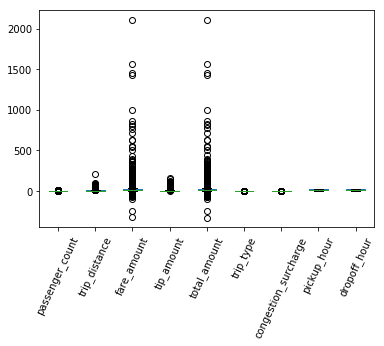

In [14]:
boxplotdf = df[['passenger_count', 'trip_distance', 'fare_amount', 'tip_amount',
               'total_amount', 'trip_type', 'congestion_surcharge', 'pickup_hour',
               'dropoff_hour']]
#sns.boxplot(x = 'variable', y = 'value', data = pd.melt(boxplotdf))
boxplotdf.plot(kind = 'box')
plt.xticks(rotation=65)

#### 2.5.1.1 Passenger count variable 

In [15]:
# pssenger_count
number_of_zero_passengers = len(df.loc[df['passenger_count'] == 0])
number_of_neg_passengers = len(df.loc[df['passenger_count'] < 0])
max_passengers = df['passenger_count'].max()
print('The [passenger_count] variable is the number of passengers in the vehicle')
print('There are {} observations that did not record passenger count values.'.format(number_of_zero_passengers))
print('There are {} observations that has negative passenger count.'.format(number_of_neg_passengers))
print('The maximum number of passengers count is {}, which is within the vehicle seating capacity.'.format(max_passengers))
print('STEP -----> impute negative observations with the mode 1.')

The [passenger_count] variable is the number of passengers in the vehicle
There are 777 observations that did not record passenger count values.
There are 0 observations that has negative passenger count.
The maximum number of passengers count is 9, which is within the vehicle seating capacity.
STEP -----> impute negative observations with the mode 1.


#### 2.5.1.2 Trip distance variable 

In [16]:
# trip_distance
number_of_zero_distance = len(df.loc[df['trip_distance'] == 0])
number_of_neg_distance = len(df.loc[df['trip_distance'] < 0])
print('The [trip_distance] variable is the elapsed trip distance in miles reported by the taximeter.')
print('There are {} observations that did not record trip distance.'.format(number_of_zero_distance))
print('There are {} observations that has negative trip distance.'.format(number_of_neg_distance))
print('STEP -----> remove observations that did not record trip distance (trip_distrance = 0).')

The [trip_distance] variable is the elapsed trip distance in miles reported by the taximeter.
There are 9089 observations that did not record trip distance.
There are 0 observations that has negative trip distance.
STEP -----> remove observations that did not record trip distance (trip_distrance = 0).


In [17]:
df['trip_distance'].quantile([0.25, 0.50, 0.75, 0.95, 0.96, 0.97, 0.98, 0.99, 0.999, 0.9999, 1])

0.2500      1.060000
0.5000      1.860000
0.7500      3.510000
0.9500      9.230000
0.9600     10.280000
0.9700     11.730000
0.9800     14.000000
0.9900     17.770000
0.9990     28.100000
0.9999     39.270572
1.0000    202.100000
Name: trip_distance, dtype: float64

In [18]:
number_of_valid_zero_distance = len(df.loc[(df['trip_distance']==0) & (df['pickup_boro']!=df['dropoff_boro'])])
number_of_valid_zero_distance

2463

#### 2.5.1.3 Fare amount variable 

In [19]:
# fare_amount
number_of_zero_fare_amount = len(df.loc[df['fare_amount'] == 0])
number_of_neg_fare_amount = len(df.loc[df['fare_amount'] < 0])
print('The [fare_amount] variable is the time-and-distance fare calcualted by the taxi meter.')
print('There are {} observations that the fare amount is zero.'.format(number_of_zero_fare_amount))
print('There are {} observations that have negative fare amount.'.format(number_of_neg_fare_amount))
print('STEP -----> remove negative observations.')

The [fare_amount] variable is the time-and-distance fare calcualted by the taxi meter.
There are 1117 observations that the fare amount is zero.
There are 1345 observations that have negative fare amount.
STEP -----> remove negative observations.


In [20]:
df['fare_amount'].quantile([0, 0.1, 0.15, 0.25, 0.50, 0.75, 0.95, 0.96, 0.97, 0.98, 0.99, 0.999, 0.9999])

0.0000   -324.0
0.1000      5.0
0.1500      5.5
0.2500      6.5
0.5000     10.0
0.7500     15.5
0.9500     34.5
0.9600     38.0
0.9700     42.5
0.9800     50.0
0.9900     59.0
0.9990     92.0
0.9999    205.0
Name: fare_amount, dtype: float64

According to online references from Kaggle, negative fare amounts are stored in a database to show for amount refunded due to a variety of reasons, such as incorrect charge on the card and cancelled trip but charged incorrectly. It is suggested to remove rows with negative fare amount. 
Reference link: https://www.kaggle.com/c/new-york-city-taxi-fare-prediction/discussion/62293

#### 2.5.1.4 Tip amount variable

In [21]:
# Tip amount
number_of_neg_tip = len(df.loc[df['tip_amount'] < 0])
number_of_twice_tip = len(df.loc[df['tip_amount'] > 2*df['fare_amount']])
print('The [tip_amount] variable is automatically populated for credit card tips. Cash tips are not included.')
print('There are {} observations that have negative tip values.'.format(number_of_neg_tip))
print('There are {} observations that the tip amount is twice the fare amount.'.format(number_of_twice_tip))
print('STEP -----> remove negative observations and implausible observations.')

The [tip_amount] variable is automatically populated for credit card tips. Cash tips are not included.
There are 17 observations that have negative tip values.
There are 1574 observations that the tip amount is twice the fare amount.
STEP -----> remove negative observations and implausible observations.


Since cash tips are not included, we need to exclude all observations whose payment type is not credit card. In other words, only trasactions that were made using credit card can be used in modeling when predict taxi tips. 

#### 2.5.1.5 Total amount variable 

In [22]:
# Total amount
number_of_abnormal_totalamount = len(df.loc[df['total_amount'] <= df['tip_amount']])
number_of_neg_totalamount = len(df.loc[df['total_amount'] < 0])
number_of_zero_totalamount = len(df.loc[df['total_amount'] == 0])
print('The [total_amount] variable is the total amount charged to passengers. It does not include cash tips.')
print('There are {} observations that total fare amount is smaller than tip amount.'.format(number_of_abnormal_totalamount))
print('There are {} observations that have negative total fare amount.'.format(number_of_neg_totalamount))
print('There are {} observations that have zero total fare amount.'.format(number_of_zero_totalamount))
print('STEP -----> remove negative observations.')

The [total_amount] variable is the total amount charged to passengers. It does not include cash tips.
There are 2412 observations that total fare amount is smaller than tip amount.
There are 1345 observations that have negative total fare amount.
There are 1060 observations that have zero total fare amount.
STEP -----> remove negative observations.


#### 2.5.1.6 Trip Time 

In [23]:
# Trip time
number_of_neg_triptime = len(df.loc[df['trip_time'] < 0])
number_of_zero_triptime = len(df.loc[df['trip_time'] == 0])
print('There are {} observations that have negative trip time.'.format(number_of_neg_triptime))
print('There are {} observations that have zero trip time.'.format(number_of_zero_triptime))
print('STEP -----> remove negative observations.')

There are 0 observations that have negative trip time.
There are 8680 observations that have zero trip time.
STEP -----> remove negative observations.


In [24]:
df['trip_time'].quantile([0.25, 0.50, 0.75, 0.95, 0.96, 0.97, 0.98, 0.99, 0.999, 0.9999])

0.2500       6.0
0.5000      11.0
0.7500      18.0
0.9500      41.0
0.9600      45.0
0.9700      51.0
0.9800      61.0
0.9900      82.0
0.9990    1428.0
0.9999    1438.0
Name: trip_time, dtype: float64

#### 2.5.1.7 Trip speed 

In [25]:
df['trip_speed'].quantile([0.25, 0.50, 0.75, 0.95, 0.96, 0.97, 0.98, 0.99, 0.999, 0.9999])

0.2500    0.142857
0.5000    0.183571
0.7500    0.238750
0.9500    0.383077
0.9600    0.403225
0.9700    0.430000
0.9800    0.466667
0.9900    0.527895
0.9990    0.743309
0.9999    3.345533
Name: trip_speed, dtype: float64

### 2.5.2 Data cleaning

#### Based on the above analysis, records that met the following criteria were excluded from all subsequent analysis:
1. Distance of 0 mile (invalid observations only) or distance > 40 miles (99.99% percentile was 39.270572 miles);
2. Trip time of 0 minute (invalid observations only) or trip time > 82 mins (99% percentile was 82 minutes);
3. Fare amount (fare excluding tips and tax) < USD 2.50;
4. Tip amount > twice the fare amount;
5. Trip speed >= 240 MPH

It should be noticed that trips of 0 mile or trips of 0 minute are not necessarily invalid. This is because long-distance taxi rides could be charged a flat rate or negatiated fare, in which case the driver may not necessarily use the meter to calculate the price. Therefore, we cannot remove all trips of 0 mile or 0 minute, but need to retain trips that have valid GPS data, which shows that the trip has cross-borough information. The distances and duration of these trips will be imputed in section 2.4.3 based on the fare amount and rate code.  

#### 2.5.2.1 Distance 

In [26]:
# remove trips with extreme distances
# i) for trips with distance of 0 mile, keep trips that have different pickup and dropoff locations
filter1 = (df['trip_distance'] == 0) & (df['pickup_boro'] != df['dropoff_boro'])

# ii) keep trips with distance > = and < 40 miles (99.99% percentile was 39.270572 miles)
filter2 = (df['trip_distance'] > 0) & (df['trip_distance'] < 40)

# apply filters 
start_n = len(df)
df = df[filter1 | filter2]
print('Step 1 excludes', start_n - len(df), 'records, which is', 
      round((start_n - len(df)) / start_n * 100, 2), '% of the sample size.', 
      'Current sample size is', len(df)) 

Step 1 excludes 6671 records, which is 1.42 % of the sample size. Current sample size is 464381


#### 2.5.2.2 Trip time (duration) 

In [27]:
# remove trips with extreme duration:
# i) for trips with duration of 0 minute, keep trips with different pickup and dropoff locations
filter3 = (df['trip_time'] == 0) & (df['pickup_boro'] != df['dropoff_boro'])

# ii) keep trips with distance > 0 min and <= 82 mins (99% percentile was 82 mins)
filter4 = (df['trip_time'] > 0) & (df['trip_time'] <= 82.0)

# apply filters
start_n_2 = len(df)
df = df[filter3 | filter4]
print('Step 2 excludes', start_n_2 - len(df), 'records, which is', 
      round((start_n_2 - len(df)) / start_n * 100, 2), '% of the original sample size.',
      'Current sample size is', len(df)) 

Step 2 excludes 8164 records, which is 1.73 % of the original sample size. Current sample size is 456217


#### 2.5.2.3 Fare amount 

In [28]:
# remove trips with extreme fare amount
# i) keep trips with fare >= the minimum amount USD 2.50
# 2) keep trips with fare <= USD 205 (99.99% percentile was 205.0)
filter5 = (df['fare_amount'] >= 2.5) & (df['fare_amount'] <= 205.0)

# apply filters
start_n_3 = len(df)
df = df[filter5]
print('Step 3 excludes', start_n_3 - len(df), 'records, which is', 
      round((start_n_3 - len(df)) / start_n * 100, 2), '% of the original sample size.',
      'Current sample size is', len(df)) 

Step 3 excludes 1628 records, which is 0.35 % of the original sample size. Current sample size is 454589


#### 2.5.2.4 Tip amount 

In [29]:
# remove trips with implausible tip amount
# i) keep trips with tip amount >= 0 and <= twice the fare amount(implausible values)
filter6 = (df['tip_amount'] >= 0) & (df['tip_amount'] <= 2*df['fare_amount'])

# apply filter
start_n_4 = len(df)
df = df[filter6]
print('Step 4 excludes', start_n_4 - len(df), 'records, which is', 
      round((start_n_4 - len(df)) / start_n * 100, 2), '% of the original sample size.',
      'Current sample size is', len(df)) 

Step 4 excludes 81 records, which is 0.02 % of the original sample size. Current sample size is 454508


#### 2.5.2.5 Trip speed 

In [30]:
# remove trip speed greater than 240 MPH
filter7 = df['trip_speed'] < 4

# apply filter
start_n_5 = len(df)
df = df[filter7]
print('Step 4 excludes', start_n_5 - len(df), 'records, which is', 
      round((start_n_5 - len(df)) / start_n * 100, 2), '% of the original sample size.',
      'Current sample size is', len(df)) 

Step 4 excludes 36 records, which is 0.01 % of the original sample size. Current sample size is 454472


#### 2.5.2.6 Check

In [31]:
df.describe()
# The results below shows that at least there is no negative fare amount trips or negative tip amount trips

vendorid     ratecodeid   pulocationid   dolocationid  \
count  454472.000000  454472.000000  454472.000000  454472.000000   
mean        1.839819       1.061185     106.553909     129.660932   
std         0.366775       0.482436      70.937873      76.558671   
min         1.000000       1.000000       3.000000       1.000000   
25%         2.000000       1.000000      52.000000      65.000000   
50%         2.000000       1.000000      82.000000     129.000000   
75%         2.000000       1.000000     165.000000     193.000000   
max         2.000000       6.000000     265.000000     265.000000   

       passenger_count  trip_distance    fare_amount          extra  \
count    454472.000000  454472.000000  454472.000000  454472.000000   
mean          1.319465       2.966907      13.097237       0.381693   
std           0.980924       3.186526      10.146244       0.564766   
min           0.000000       0.000000       2.500000       0.000000   
25%           1.000000       1.100000       7.000000       0.000000   
50%           1.000000       1.900000      10.000000       0.000000   
75%           1.000000       3.530000      15.500000       0.500000   
max           9.000000      39.780000     200.000000       7.250000   

             mta_tax     tip_amount      ...        ehail_fee  \
count  454472.000000  454472.000000      ...              0.0   
mean        0.492110       1.108734      ...              NaN   
std         0.062314       1.931148      ...              NaN   
min         0.000000       0.000000      ...              NaN   
25%         0.500000       0.000000      ...              NaN   
50%         0.500000       0.000000      ...              NaN   
75%         0.500000       1.890000      ...              NaN   
max         0.500000      90.000000      ...              NaN   

       improvement_surcharge   total_amount   payment_type      trip_type  \
count          454472.000000  454472.000000  454472.000000  454472.000000   
mean                0.295303      15.929629       1.454453       1.014786   
std                 0.037242      11.619379       0.509662       0.120697   
min                 0.000000       2.830000       1.000000       1.000000   
25%                 0.300000       8.600000       1.000000       1.000000   
50%                 0.300000      12.300000       1.000000       1.000000   
75%                 0.300000      19.050000       2.000000       1.000000   
max                 0.300000     216.960000       5.000000       2.000000   

       congestion_surcharge    pickup_hour   dropoff_hour      trip_time  \
count         454472.000000  454472.000000  454472.000000  454472.000000   
mean               0.424425      13.835563      13.901693      14.328502   
std                0.993344       5.898573       5.969873      11.853038   
min                0.000000       0.000000       0.000000       0.000000   
25%                0.000000      10.000000      10.000000       6.000000   
50%                0.000000      15.000000      15.000000      11.000000   
75%                0.000000      18.000000      19.000000      18.000000   
max                2.750000      23.000000      23.000000      82.000000   

          trip_speed  
count  454472.000000  
mean        0.205302  
std         0.096508  
min         0.000000  
25%         0.146500  
50%         0.186000  
75%         0.240769  
max         3.990000  

[8 rows x 21 columns]

### 2.5.3 Data Imputing 

#### 2.5.3.1 Impute distance and trip time (duration)

In [32]:
# Caculate median speed for valid trips
median_speed = df['trip_speed'].loc[(df['trip_distance'] > 0) & (df['trip_time'] > 0)].median()
median_speed

0.18666666666666665

In [33]:
# index type of data error
dist_0 = (df['trip_distance'] == 0) & (df['trip_time'] > 0)
time_0 = (df['trip_distance'] > 0) & (df['trip_time'] == 0)
ratecode_JFK = (df['trip_distance'] == 0) & (df['trip_time'] == 0) & (df['ratecodeid'] == 2) # JFK trips
ratecode_Newark = (df['trip_distance'] == 0) & (df['trip_time'] == 0) & (df['ratecodeid'] == 3) # Newwark trips
other_error = (df['trip_distance'] == 0) & (df['trip_time'] == 0) & (df['ratecodeid'] != ratecode_JFK) & (df['ratecodeid'] != ratecode_Newark)

###### 2.5.3.1.1  data error 1

In [34]:
len(df.loc[dist_0])

1339

In [35]:
# i) data error situation 1: dist_0 = (df['trip_distance'] == 0) & (df['trip_time'] > 0)
# replace distance by median speed * trip time
#df['trip_distance'].loc[dist_0] = df['trip_time'].loc[dist_0] * median_speed

#trip_distance_column_index = list(df.columns).index('trip_distance')
row_index_1 = list(df.loc[dist_0].index.values)
df.loc[row_index_1, ['trip_distance']] = df['trip_time'].loc[dist_0] * median_speed

# reference: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html

In [36]:
len(df.loc[(df['trip_distance'] == 0) & (df['trip_time'] > 0)])

0

###### 2.5.3.1.2 Data error 2: time == 0

In [37]:
len(df.loc[time_0])

165

In [38]:
# ii) data error situation 2: time_0 = (df['trip_distance'] > 0) & (df['trip_time'] == 0)
# replace trip time by distance / median speed
#df['trip_time'].loc[time_0] = df['trip_distance'].loc[time_0]/median_speed

row_index_2 = list(df.loc[time_0].index.values)
df.loc[row_index_2, ['trip_time']] = df['trip_distance'].loc[time_0] / median_speed

In [39]:
len(df.loc[(df['trip_distance'] > 0) & (df['trip_time'] == 0)])

0

##### 2.5.3.1.3 Data error 3: JFK

In [40]:
len(df.loc[ratecode_JFK])

14

In [41]:
# iii) data error situation 3 (JFK): trips with distance == 0 and time == 0 and rate code == 2
# replace by median distance and time for rate code == 2

row_index_3 = list(df.loc[ratecode_JFK].index.values)
# trip distance
df.loc[row_index_3, ['trip_distance']] = df['trip_distance'].loc[(df['trip_distance'] > 0) & \
                                                                          (df['trip_time'] > 0) & \
                                                                          (df['ratecodeid'] == 2)].median()
# trip time
df.loc[row_index_3, ['trip_time']] = df['trip_time'].loc[(df['trip_distance'] > 0) &\
                                                                  (df['trip_time'] > 0) &\
                                                                  (df['ratecodeid'] == 2)].median()

In [42]:
len(df.loc[(df['trip_distance'] == 0) & (df['trip_time'] == 0) & (df['ratecodeid'] == 2)])

0

##### 2.5.3.1.4 Data error 4: Newark 

In [43]:
len(df.loc[ratecode_Newark])

2

In [44]:
# iv) data error situation 4 (Newark): trips with distance == 0 and time == 0 and rate code == 3
# replace by median distance and time for rate code == 3

row_index_4 = list(df.loc[ratecode_Newark].index.values)
# trip distance
df.loc[row_index_4, ['trip_distance']] = df['trip_distance'].loc[(df['trip_distance'] > 0) & \
                                                                          (df['trip_time'] > 0) & \
                                                                          (df['ratecodeid'] == 3)].median()
# trip time
df.loc[row_index_4, ['trip_time']] = df['trip_time'].loc[(df['trip_distance'] > 0) &\
                                                                  (df['trip_time'] > 0) &\
                                                                  (df['ratecodeid'] == 3)].median()

In [45]:
len(df.loc[(df['trip_distance'] == 0) & (df['trip_time'] == 0) & (df['ratecodeid'] == 3)])

0

##### 2.5.3.1.5 Data eoor 5: other error 

In [46]:
len(df.loc[other_error])

966

In [47]:
# v) other data error: trips with distance == 0 and time == 0 and rate code != 2 and != 3
# replaced by median distance per dollar fare or median time per dollar fare

time_per_usd = (df['trip_time'] / df['fare_amount']).median()
distance_per_usd = (df['trip_distance'] / df['fare_amount']).median()

row_index_5 = list(df.loc[other_error].index.values)
# trip distance
df.loc[row_index_5, ['trip_distance']] = df['fare_amount'].loc[other_error] * distance_per_usd
# trip time
df.loc[row_index_5, ['trip_time']] = df['fare_amount'].loc[other_error] * time_per_usd

In [48]:
len(df.loc[(df['trip_distance'] == 0) & (df['trip_time'] == 0) & (df['ratecodeid'] != ratecode_JFK) & (df['ratecodeid'] != ratecode_Newark)])

0

#### 2.5.3.2 Recalculate trip speed 

In [49]:
# recalculate speed after impution
df['trip_speed'] = df['trip_distance'] / df['trip_time']

#### 2.5.3.3 Impute Passenger count 

In [50]:
# passenger_count_mode = df['passenger_count'].mode()
# row_index_pc_0 = list(df.loc[df['passenger_count']==0].index.values)
# passenger_count_column_index = list(df.columns).index('passenger_count')
# df.loc[row_index_pc_0, passenger_count_column_index] = 1

In [51]:
df['passenger_count'].mode()

0    1
dtype: int64

In [54]:
len(df.loc[df['passenger_count'] == 0])

672

In [55]:
# impute 0 with 1
row_index_passenger_count_0 = list(df.loc[df['passenger_count'] == 0].index.values)
df.loc[row_index_passenger_count_0, ['passenger_count']] = 1

In [57]:
len(df.loc[df['passenger_count'] == 0])

0

# 3 Exploratory Data Analysis

## 3.1 NYC Taxi Dropoffs Heatmap

In [58]:
import bokeh, bokeh.plotting, bokeh.models
from bokeh.palettes import Blues8
Blues8.reverse()
from bokeh.io import output_notebook, show, export_svgs
output_notebook()

Loading BokehJS ...

In [59]:
# Create the trip dataframe for plotting 
trips = df[['pulocationid', 'dolocationid']]
counts = trips.groupby('dolocationid').count()
counts.columns = ['N']
counts = counts.reset_index()
counts.head(2)

dolocationid    N
0             1  152
1             2    3

In [60]:
# check the distribution of dropoffs
counts['N'].describe()

count      259.000000
mean      1754.718147
std       2705.397869
min          1.000000
25%        361.000000
50%        775.000000
75%       2058.000000
max      18586.000000
Name: N, dtype: float64

In [61]:
counts.loc[counts['N'] == counts['N'].max()]

dolocationid      N
72            74  18586

In [62]:
# merge lookup table with counts table
counts = counts.merge(lookup[['borough', 'zone', 'locationid']], 
              how = 'left', left_on = 'dolocationid', right_on = 'locationid')
counts.drop(columns = ['locationid'], inplace = True)
counts.head(2)

dolocationid    N borough            zone
0             1  152     EWR  Newark Airport
1             2    3  Queens     Jamaica Bay

In [67]:
counts_sorted = counts.sort_values(by='N', ascending=False)
counts_sorted.head()

dolocationid      N    borough                  zone
72            74  18586  Manhattan     East Harlem North
41            42  16854  Manhattan  Central Harlem North
40            41  15057  Manhattan        Central Harlem
73            75  12888  Manhattan     East Harlem South
6              7  12662     Queens               Astoria

In [63]:
# set the coordinate system to 'epsg:4326', which is latitude and longitude coordinates
coord_system = {'init': 'epsg:4326'}

# load the shapefile in Geeopandas
# and convert geometric coordinates to places on the Eearth using CRS
#shape_df = gpd.read_file('Taxi_Zones/taxi_zones.shp').to_crs(coord_system)
shape_df = gpd.read_file('Taxi_Zones/taxi_zones.shp')

# drop unrelated columns
shape_df = shape_df.drop(['OBJECTID', 'Shape_Leng', 'Shape_Area', 'borough', 
                          'zone'], axis = 1)
shape_df.head(2)

LocationID                                           geometry
0           1  POLYGON ((933100.9183527103 192536.0856972019,...
1           2  (POLYGON ((1033269.243591294 172126.0078125, 1...

In [64]:
# merge the trip counts info with shape_df
counts2 = shape_df.merge(counts, left_on='LocationID', right_on = 'dolocationid', 
                         how='left')
counts2.head(2)

LocationID                                           geometry  \
0           1  POLYGON ((933100.9183527103 192536.0856972019,...   
1           2  (POLYGON ((1033269.243591294 172126.0078125, 1...   

   dolocationid      N borough            zone  
0           1.0  152.0     EWR  Newark Airport  
1           2.0    3.0  Queens     Jamaica Bay

In [65]:
# Plot
gjds = bokeh.models.GeoJSONDataSource(geojson=counts2.to_json())
TOOLS = "pan,wheel_zoom,reset,hover,save"

purples = ['#fcfbfd', '#efedf5', '#dadaeb', '#bcbddc', '#9e9ac8', '#807dba', '#6a51a3', '#54278f', '#3f007d']
plasma = bokeh.palettes.Plasma256
viridis = bokeh.palettes.Viridis256
p = bokeh.plotting.figure(title="NYC Taxi Dropoffs Heatmap", 
                          tools=TOOLS,plot_width=100, plot_height=100,
                          x_axis_location=None, y_axis_location=None,
                          sizing_mode='scale_width')
color_mapper = bokeh.models.LogColorMapper(palette=viridis,low=1,high=20000)

p.patches('xs', 'ys', 
          fill_color={'field': 'N', 'transform': color_mapper},
          fill_alpha=1., line_color="white", line_width=0.1,          
          source=gjds)

p.grid.grid_line_color = None

hover = p.select_one(bokeh.models.HoverTool)
hover.point_policy = "follow_mouse"
hover.tooltips = u"""
<div> 
    <div class="bokeh_hover_tooltip">Name : @zone</div>
    <div class="bokeh_hover_tooltip">Borough : @borough</div>
    <div class="bokeh_hover_tooltip">Zone ID : @LocationID</div>
    <div class="bokeh_hover_tooltip"># of Trips : @N</div>
</div>
"""
color_bar = bokeh.models.ColorBar(
    color_mapper=color_mapper, orientation='horizontal',
    ticker=bokeh.models.FixedTicker(ticks=[3, 8, 20, 50, 150, 400, 1100, 3000, 8000, 20000]),
    formatter=bokeh.models.PrintfTickFormatter(format='%d'),
    label_standoff=12, border_line_color='White', location=(0,0),major_label_text_font_size="8pt")
p.add_layout(color_bar, 'below')

show(p)

# bokeh heatmap: https://nbviewer.jupyter.org/github/r-shekhar/NYC-transport/blob/master/15_dataframe_analysis/spatialjoin_geopandas_dask.ipynb
# bokeh color: https://docs.bokeh.org/en/latest/docs/reference/palettes.html

In [ ]:
# save figure
#p.output_backend='svg' 
#export_svgs(p,filename='dropoffs_heatmap.svg')

## 3.2 Pick up heatmap 

In [90]:
# Create the trip dataframe for plotting 
trips = df[['pulocationid', 'dolocationid']]
counts = trips.groupby('pulocationid').count()
counts.columns = ['N']
counts = counts.reset_index()

# merge lookup table with counts table
counts = counts.merge(lookup[['borough', 'zone', 'locationid']], 
              how = 'left', left_on = 'pulocationid', right_on = 'locationid')
counts.drop(columns = ['locationid'], inplace = True)

# set the coordinate system to 'epsg:4326', which is latitude and longitude coordinates
coord_system = {'init': 'epsg:4326'}

# load the shapefile in Geeopandas
# and convert geometric coordinates to places on the Eearth using CRS
shape_df = gpd.read_file('Taxi_Zones/taxi_zones.shp')

# drop unrelated columns
shape_df = shape_df.drop(['OBJECTID', 'Shape_Leng', 'Shape_Area', 'borough', 
                          'zone'], axis = 1)

# merge the trip counts info with shape_df
counts2 = shape_df.merge(counts, left_on='LocationID', right_on = 'pulocationid', 
                         how='left')

# Plot
gjds = bokeh.models.GeoJSONDataSource(geojson=counts2.to_json())
TOOLS = "pan,wheel_zoom,reset,hover,save"

purples = ['#fcfbfd', '#efedf5', '#dadaeb', '#bcbddc', '#9e9ac8', '#807dba', '#6a51a3', '#54278f', '#3f007d']
plasma = bokeh.palettes.Plasma256
viridis = bokeh.palettes.Viridis256
p = bokeh.plotting.figure(title="NYC Taxi Pickups Heatmap", 
                          tools=TOOLS,plot_width=100, plot_height=100,
                          x_axis_location=None, y_axis_location=None,
                          sizing_mode='scale_width')
color_mapper = bokeh.models.LogColorMapper(palette=plasma,low=1,high=40000)

p.patches('xs', 'ys', 
          fill_color={'field': 'N', 'transform': color_mapper},
          fill_alpha=1., line_color="white", line_width=0.1,          
          source=gjds)

p.grid.grid_line_color = None

hover = p.select_one(bokeh.models.HoverTool)
hover.point_policy = "follow_mouse"
hover.tooltips = u"""
<div> 
    <div class="bokeh_hover_tooltip">Name : @zone</div>
    <div class="bokeh_hover_tooltip">Borough : @borough</div>
    <div class="bokeh_hover_tooltip">Zone ID : @LocationID</div>
    <div class="bokeh_hover_tooltip"># of Trips : @N</div>
</div>
"""
color_bar = bokeh.models.ColorBar(
    color_mapper=color_mapper, orientation='horizontal',
    ticker=bokeh.models.FixedTicker(ticks=[3, 10, 35, 120, 400, 1300, 3600, 12000, 40000]),
    formatter=bokeh.models.PrintfTickFormatter(format='%d'),
    label_standoff=12, border_line_color='White', location=(0,0),major_label_text_font_size="8pt")
p.add_layout(color_bar, 'below')

show(p)

In [69]:
counts_sorted = counts.sort_values(by='N', ascending=False)
counts_sorted.head()

pulocationid      N    borough               zone
70            74  38459  Manhattan  East Harlem North
71            75  29943  Manhattan  East Harlem South
38            41  27901  Manhattan     Central Harlem
78            82  22084     Queens           Elmhurst
4              7  20849     Queens            Astoria

In [70]:
# check the distribution of pickups
counts['N'].describe()

count      246.000000
mean      1847.447154
std       4818.070758
min          1.000000
25%         39.000000
50%        300.500000
75%        992.750000
max      38459.000000
Name: N, dtype: float64